About the problem

A data frame with 53940 rows and 10 variables:
price
price in US dollars (\$326--\$18,823)
carat
weight of the diamond (0.2--5.01)
cut
quality of the cut (Fair, Good, Very Good, Premium, Ideal)
color
diamond colour, from J (worst) to D (best)
clarity
a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
x
length in mm (0--10.74)
y
width in mm (0--58.9)
z
depth in mm (0--31.8)
depth
total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
table
width of top of diamond relative to widest point (43--95)

# Abstract of results
Random Forest Regressor accuracy: 
Cross val     :  [0.98125892 0.98214273 0.98238088 0.98118441 0.98298683 0.98197969
 0.98141658 0.98254706 0.98076029 0.9819723 ]
R2            :  0.9828692683544198
MAE           :  266.44071204317225
MSE (RMSE)    :  269283.396787312  ( 518.925232367161 )

# import libraries

In [264]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error ,accuracy_score

In [242]:
from google.colab import drive
drive.mount('/content/drive')
out = '/content/drive/MyDrive/diamond_data/diamonds.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [243]:
from pandas.io.formats.style_render import DataFrame
df = pd.read_csv(out)
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


# preproccessing

In [244]:
df0 = df.copy()

In [100]:
df0 = df0.drop(df0.loc[df0.x == 0].index)
df0 = df0.drop(df0.loc[df0.y == 0].index)
df0 = df0.drop(df0.loc[df0.z == 0].index)

In [101]:
df0 = df0.drop(df0.loc[df0.y > 35].index)
df0 = df0.drop(df0.loc[df0.z > 25].index)

In [102]:
df0['vol']=df0['x']*df0['y']*df0['z']
df0=df0.drop(['x','y','z'],axis=1)

In [ ]:
df0.drop('Unnamed: 0',axis=1)

In [107]:
df0['cut'].replace(['Ideal','Premium','Good','Very Good','Fair'],[5,4,2,3,1],inplace=True)
df0['clarity'].replace(['I1' , 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF'],[1,2,3,4,5,6,7,8],inplace=True)
df0['color'].replace(['D','E','F','G','H','I','J'],[7,6,5,4,3,2,1],inplace=True)

In [265]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


In [186]:
df0.describe()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,vol
count,53906.000000,53906.000000,53906.000000,53906.000000,53906.000000,53906.000000,53906.000000,53906.000000,53906.000000
mean,26973.082755,0.797525,3.904371,4.406170,4.051627,61.749393,57.455920,3929.631191,129.797974
std,15572.055118,0.473662,1.116397,1.701301,1.647091,1.431508,2.227763,3986.064140,76.449011
min,1.000000,0.200000,1.000000,1.000000,1.000000,43.000000,43.000000,326.000000,31.707984
25%,13485.250000,0.400000,3.000000,3.000000,3.000000,61.000000,56.000000,949.000000,65.187639
50%,26977.500000,0.700000,4.000000,4.000000,4.000000,61.800000,57.000000,2400.000000,114.840180
75%,40458.750000,1.040000,5.000000,6.000000,5.000000,62.500000,59.000000,5320.750000,170.843743
max,53940.000000,5.010000,5.000000,7.000000,8.000000,79.000000,79.000000,18823.000000,790.133208


In [190]:
((df0['depth'] < 45 ) ).sum()

3

In [140]:
((df0['vol'] < 120 ) & (df0['carat'] > 1 ) & (df0['carat'] < 2 )).sum()

5

In [172]:
df0 = df0.drop(df0.loc[df0.depth < 270].index & df0.loc[df0.depth > 1.9].index   &  df0.loc[df0.carat < 2.2].index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead



In [196]:
df0=df0.drop('Unnamed: 0',axis=1)

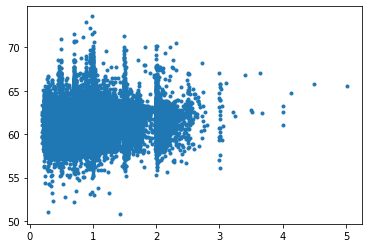

In [194]:
plt.scatter(df0['carat'], df0['depth'], 
           cmap = 'viridis',
            marker = '.')

In [193]:
df0 = df0.drop(df0.loc[df0.depth < 45].index)

In [191]:
((df0['depth'] > 75 )).sum()

3

In [195]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
fig = px.scatter_matrix(df0,
                    dimensions=["carat", "cut", "color", "clarity", "depth", "table","vol","price"],
                    color="price",
                    hover_data=['carat', 'depth'],
                    width=600,
                    height=600)#,"vol"

# Hides the linear self correlations (I haven't figured out how to put histograms here)
fig.update_traces(diagonal_visible=False, showupperhalf=True)
# landscape legend underneath
fig.update_layout(legend_orientation="h")
fig.show()

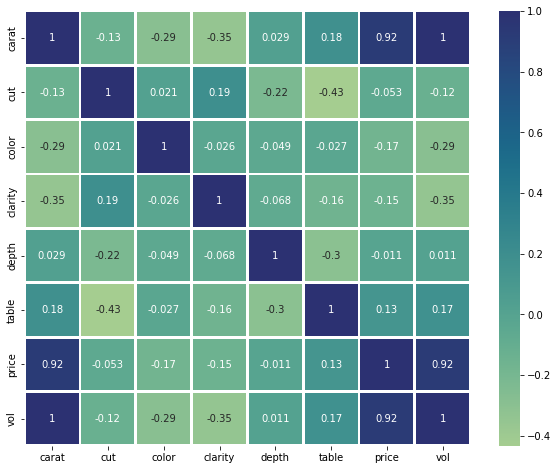

In [240]:
correlation= df0.corr()#calculate correlation of features
f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(correlation,cmap="crest",annot=True,linewidths=2)#show the correlation on map.

# split dataset to 'features' & 'target'

In [231]:
df00 =df0.copy()
df00 =df00.drop('carat',axis=1)

# split dataset to x & y

In [236]:
X = df00.drop(['price'],axis=1)
y = df00['price']

# split  x ,y to train and test

In [257]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Normalization

In [258]:
scaler=StandardScaler()

X_train_s=X_train.copy()
X_train_s[['vol','table','depth','cut']]=scaler.fit_transform(X_train_s[['vol','table','depth','cut']])#'color','clarity'
normalized_x_train = pd.DataFrame(X_train_s, columns = X_train.columns)
X_train=normalized_x_train
X_test_s=X_test.copy()
X_test_s[['vol','table','depth','cut']]=scaler.transform(X_test_s[['vol','table','depth','cut']])
normalized_x_test = pd.DataFrame(X_test_s, columns = X_test.columns)
X_test=normalized_x_test

# Train model and predict

In [213]:
# ===================================================== LinearRegression model =========================================
# from sklearn.linear_model import LinearRegression
# regressor = LinearRegression()
# regressor.fit(X_train, y_train)
# from sklearn import metrics
# from sklearn.metrics import r2_score
# y_pred_reg = regressor.predict(X_test)
# accuracy = r2_score(y_test, y_pred_reg)
# print(" accuracy is:", accuracy)

 accuracy is: 0.9079297640461061


In [ ]:
# ===================================================== DecisionTreeRegressor model =========================================
# from sklearn.tree import DecisionTreeRegressor
# tree_reg = DecisionTreeRegressor(random_state = 42)
# tree_reg.fit(X_train, y_train)
# y_pred_tree = tree_reg.predict(X_test)
# accuracy_tree = r2_score(y_test, y_pred_tree)
# print("accuracy is:", accuracy_tree)
# #test_size = 0.4

accuracy is: 0.9675964876483558


In [259]:
# ===================================================== RandomForestRegressor model =========================================
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train, y_train)
y_pred_tree = forest_reg.predict(X_test)
accuracy_forest = r2_score(y_test, y_pred_tree)
print("accuracy is:", accuracy_forest)
#test_size = 0.1

accuracy is: 0.9815616008941936


In [203]:
# ===================================================== RandomForestRegressor validation measures =========================================
# print('Random Forest Regressor accuracy: ')
# crossr = cross_val_score(estimator = forest_reg, X = X_train, y = y_train, cv = 10,verbose = 0)
# mser = mean_squared_error(y_test, y_pred_tree)
# rmser = mean_squared_error(y_test, y_pred_tree)**0.5
# maer = mean_absolute_error(y_test, y_pred_tree)
# r2r = r2_score(y_test, y_pred_tree)

# print('Cross val     : ',crossr)
# print('R2            : ', r2r)
# print('MAE           : ', maer)
# print('MSE (RMSE)    : ', mser,' (',rmser,')')

Random Forest Regressor accuracy: 
Cross val     :  [0.98125892 0.98214273 0.98238088 0.98118441 0.98298683 0.98197969
 0.98141658 0.98254706 0.98076029 0.9819723 ]
R2            :  0.9828692683544198
MAE           :  266.44071204317225
MSE (RMSE)    :  269283.396787312  ( 518.925232367161 )


# scatter(y_test, y_pred_tree)

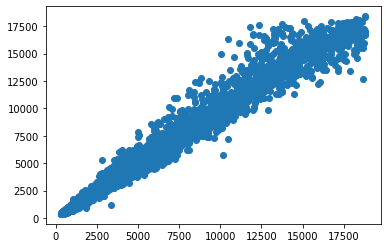

In [262]:
plt.scatter(y_test, y_pred_tree)